Librerias

In [122]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler, scale
import sqlite3
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 999
# Tratamiento de datos
# ==============================================================================
import statsmodels.api as sm
# Gráficos
# ==============================================================================
import matplotlib.font_manager
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# Tratamiento de datos
# ==============================================================================
from sklearn.datasets import make_blobs

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Ellipse


# Preprocesado y modelado
# ==============================================================================
from sklearn.mixture import GaussianMixture




In [ ]:
# Consultar datos
conn = sqlite3.connect('sp500_2.db')
cursor = conn.cursor()
cursor.execute("SELECT * FROM acciones")
column_names = [description[0] for description in cursor.description]
filas = cursor.fetchall()

# Guardar los datos en un dataframe
df = pd.DataFrame(filas, columns=column_names)
df = df.drop(df[df["beta"].isna()].index)  # Eliminar filas con valores nulos en shortName
df.isna().sum()  # Verificar si hay valores nulos
df = df.fillna(0)  # Reemplazar valores nulos por 0
# Seleccionar columnas numéricas relevantes para el clustering
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
data = df[numerical_columns]

# ¿como decido que algoritmo de clustering usar?


Interpretación

Si los datos tienen grupos bien definidos, K-Means o GMM pueden funcionar bien.

Si hay zonas de alta densidad y ruido, DBSCAN o HDBSCAN pueden ser mejores opciones.

1. Gráfico PCA (Reducción de Dimensionalidad)

Usamos PCA para proyectar los datos a 2D y ver si tienen una forma que sugiere agrupamientos naturales.

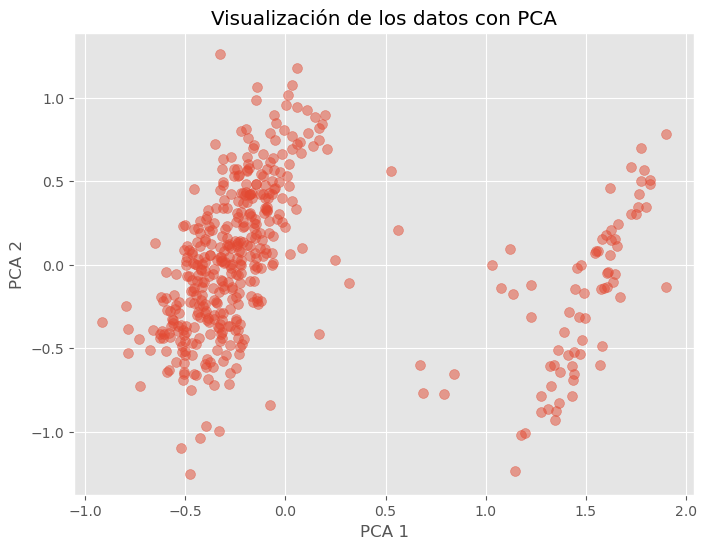

In [ ]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(data)  # Reemplazar StandardScaler


# Reducir a 2D con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Graficar los datos en el espacio reducido
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, s=50)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Visualización de los datos con PCA")
plt.show()


2. Gráfico con t-SNE (Mejor en Datos No Lineales)

Si PCA no revela bien las estructuras, t-SNE puede ser útil.

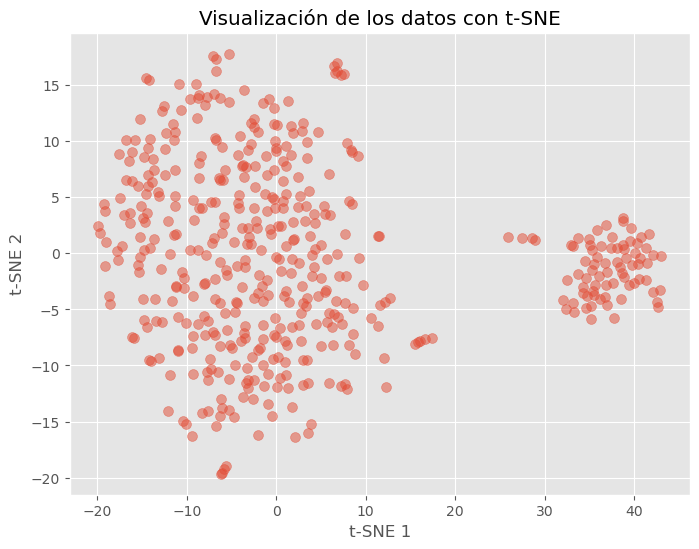

In [113]:
from sklearn.manifold import TSNE

# Reducir dimensiones con t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Graficar los datos en el espacio t-SNE
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.5, s=50)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("Visualización de los datos con t-SNE")
plt.show()

 Interpretación

Si t-SNE muestra grupos compactos, usa K-Means o GMM.

Si hay zonas con diferentes densidades, DBSCAN o OPTICS son mejores.

 3. Matriz de Distancias (Heatmap de Similaridad)
Si los datos son difíciles de visualizar, una matriz de distancia ayuda a entender su estructura.

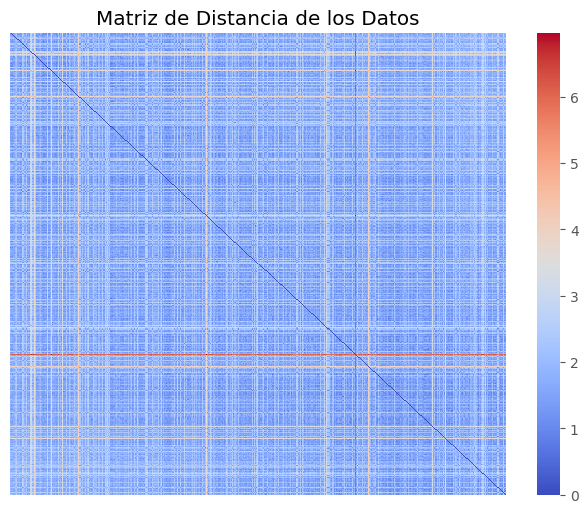

In [114]:
import seaborn as sns
from scipy.spatial.distance import pdist, squareform

# Calcular la matriz de distancia euclidiana
dist_matrix = squareform(pdist(X_scaled, metric='euclidean'))

# Graficar la matriz de distancia
plt.figure(figsize=(8, 6))
sns.heatmap(dist_matrix, cmap="coolwarm", xticklabels=False, yticklabels=False)
plt.title("Matriz de Distancia de los Datos")
plt.show()


Interpretación

Si la matriz muestra zonas bien separadas, K-Means es adecuado.

Si hay gradientes de densidad, DBSCAN es mejor.

Hasta acá parece que lo mejor es aplicar k-means ...

4. Curva Elbow y Silhouette Score (Para Elegir K en K-Means)
Si crees que K-Means es una opción, determina el mejor número de clusters con la curva elbow.

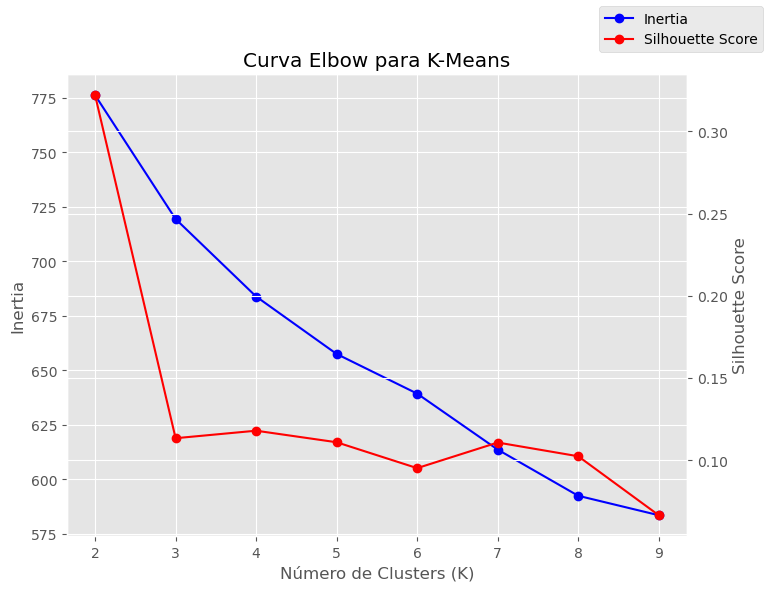

In [116]:
inertia = []
silhouette = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled, labels))

# Graficar Elbow y Silhouette Score
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.plot(K_range, inertia, 'bo-', label="Inertia")
ax1.set_xlabel("Número de Clusters (K)")
ax1.set_ylabel("Inertia")
ax1.set_title("Curva Elbow para K-Means")

ax2 = ax1.twinx()
ax2.plot(K_range, silhouette, 'ro-', label="Silhouette Score")
ax2.set_ylabel("Silhouette Score")

fig.legend()
plt.show()


El silhoutte mas alto es 775, por lo que se ve claramente que hay 2 clusters.

# Prueba 1: K-Means - DBSCAN - Clustering Jerarquico

Mejor algoritmo según la métrica de silueta: K-Means


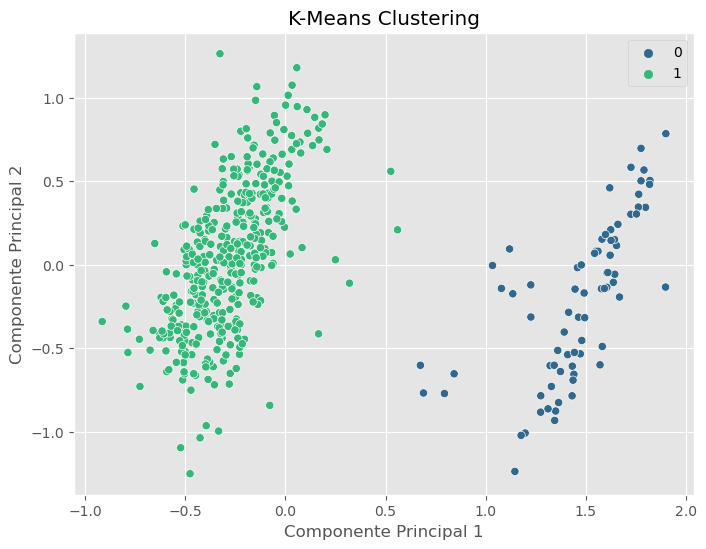

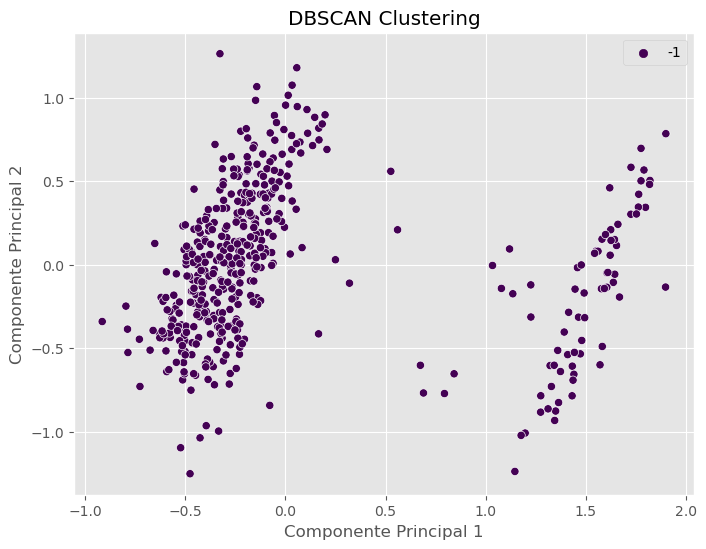

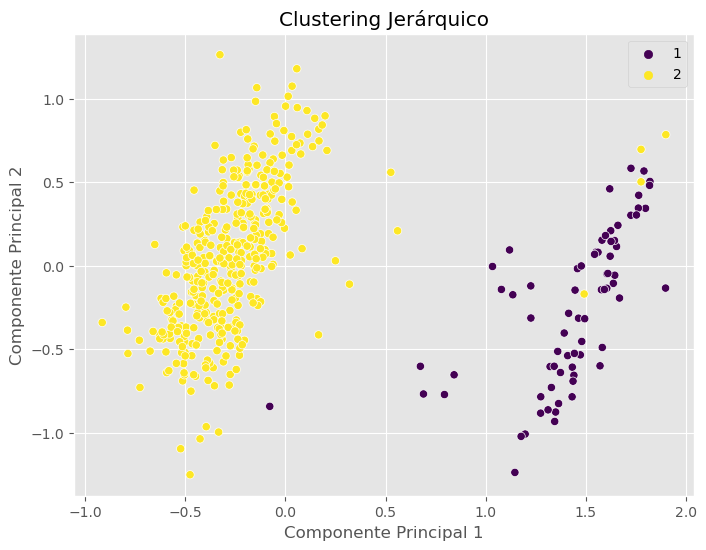

In [ ]:
# # Escalar los datos
# scaler = StandardScaler()
# data_scaled = scaler.fit_transform(data)

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)  # Reemplazar StandardScaler

# Aplicar K-Means
kmeans = KMeans(n_clusters=2, random_state=42, n_init=25)
kmeans_labels = kmeans.fit_predict(data_scaled)
kmeans_silhouette = silhouette_score(data_scaled, kmeans_labels)

# Aplicar DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(data_scaled)
dbscan_silhouette = silhouette_score(data_scaled, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1

# Aplicar Clustering Jerárquico
linkage_matrix = linkage(data_scaled, method='ward')
hierarchical_labels = fcluster(linkage_matrix, t=2, criterion='maxclust')
hierarchical_silhouette = silhouette_score(data_scaled, hierarchical_labels)

# Elegir el mejor algoritmo
scores = {
    'K-Means': kmeans_silhouette,
    'DBSCAN': dbscan_silhouette,
    'Jerárquico': hierarchical_silhouette
}
best_algorithm = max(scores, key=scores.get)
print(f"Mejor algoritmo según la métrica de silueta: {best_algorithm}")

# Reducir dimensionalidad con PCA para graficar
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

# Función para graficar resultados
def plot_clusters(labels, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=labels, palette='viridis', legend='full')
    plt.title(title)
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.show()

# Graficar cada resultado
plot_clusters(kmeans_labels, "K-Means Clustering")
plot_clusters(dbscan_labels, "DBSCAN Clustering")
plot_clusters(hierarchical_labels, "Clustering Jerárquico")


# DBSCAN

https://cienciadedatos.net/documentos/py20-clustering-con-python


In [ ]:
# # Escalar los datos
# scaler = StandardScaler()
# data_scaled = scaler.fit_transform(data)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(data)  # Reemplazar StandardScaler

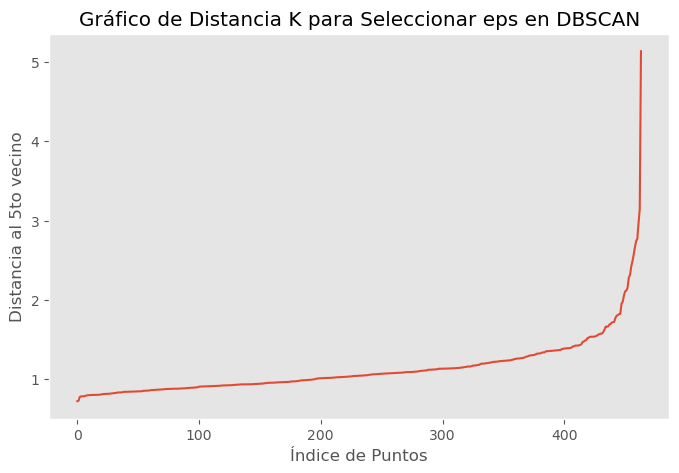

In [ ]:
# Generar un gráfico de distancia K para encontrar el mejor eps
nearest_neighbors = NearestNeighbors(n_neighbors=5)
nearest_neighbors.fit(X_scaled)
distances, indices = nearest_neighbors.kneighbors(X_scaled)
distances = np.sort(distances[:, 4])  # Tomar la 5ta distancia más cercana

# Graficar la distancia para encontrar el mejor eps
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.xlabel("Índice de Puntos")
plt.ylabel("Distancia al 5to vecino")
plt.title("Gráfico de Distancia K para Seleccionar eps en DBSCAN")
plt.grid()
plt.show()


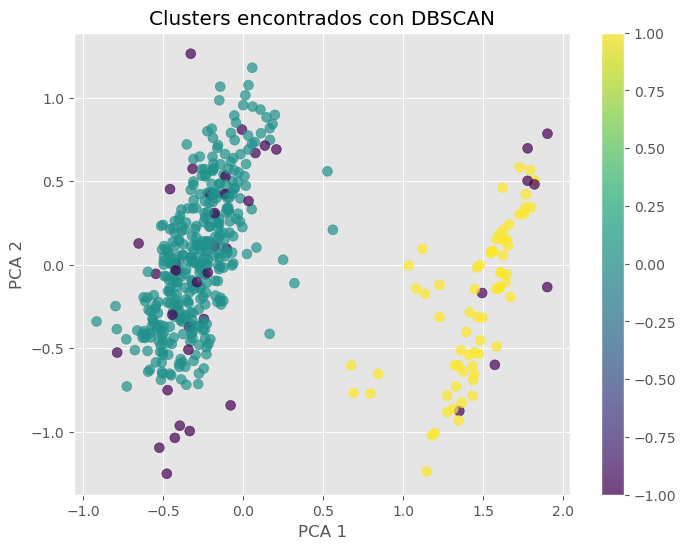

Puntos etiquetados como ruido (-1): 40
Número de clusters encontrados (excluyendo ruido): 2


In [104]:
# Ajustar el eps según el gráfico de distancia K
modelo_dbscan = DBSCAN(
    eps=1.4,  # Ajusta este valor según el gráfico
    min_samples=5,
    metric='euclidean'
)

modelo_dbscan.fit(X_scaled)
labels = modelo_dbscan.labels_

# Reducir dimensiones con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Graficar los clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
plt.colorbar(scatter)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Clusters encontrados con DBSCAN")
plt.show()

# Mostrar cuántos puntos fueron etiquetados como ruido (-1)
print(f"Puntos etiquetados como ruido (-1): {sum(labels == -1)}")
print(f"Número de clusters encontrados (excluyendo ruido): {len(set(labels)) - (1 if -1 in labels else 0)}")


# GaussianMixture

In [123]:
# Modelo
# ==============================================================================
modelo_gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=123)
modelo_gmm.fit(X=X_scaled)


# Probabilidades
# ==============================================================================
# Cada fila es una observación y cada columna la probabilidad de pertenecer a
# cada una de las componentes.
# probabilidades = modelo_gmm.predict_proba(X_scaled)


# Clasificación (asignación a la componente de mayor probabilidad)
# ==============================================================================
# Cada fila es una observación y cada columna la probabilidad de pertenecer a
# cada una de las componentes.
clasificacion = modelo_gmm.predict(X_scaled)
clasificacion

array([2, 1, 1, 2, 1, 3, 3, 1, 2, 1, 1, 3, 3, 2, 2, 3, 1, 1, 1, 2, 1, 1,
       3, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 3, 2, 2, 1, 1, 2, 2, 2, 1,
       1, 1, 1, 3, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 2, 3, 2, 1, 2, 1, 3,
       1, 2, 1, 1, 3, 2, 3, 3, 2, 1, 2, 1, 3, 2, 2, 1, 1, 3, 1, 2, 3, 1,
       1, 3, 2, 3, 1, 3, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1,
       1, 2, 1, 3, 1, 1, 3, 1, 2, 3, 1, 1, 2, 1, 1, 1, 3, 3, 3, 2, 2, 1,
       1, 3, 1, 2, 2, 2, 3, 1, 2, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 3,
       1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2,
       1, 2, 1, 1, 3, 1, 3, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 2, 2, 1, 1, 2,
       1, 1, 1, 2, 3, 2, 1, 1, 2, 1, 3, 2, 2, 1, 2, 3, 1, 1, 2, 1, 1, 1,
       1, 1, 2, 2, 1, 1, 3, 1, 3, 1, 3, 2, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1,
       1, 2, 1, 1, 2, 1, 1, 2, 1, 3, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1,
       2, 2, 2, 2, 3, 2, 1, 2, 1, 3, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1,
       1, 1, 1, 1, 3, 1, 2, 1, 1, 1, 3, 3, 3, 2, 1,

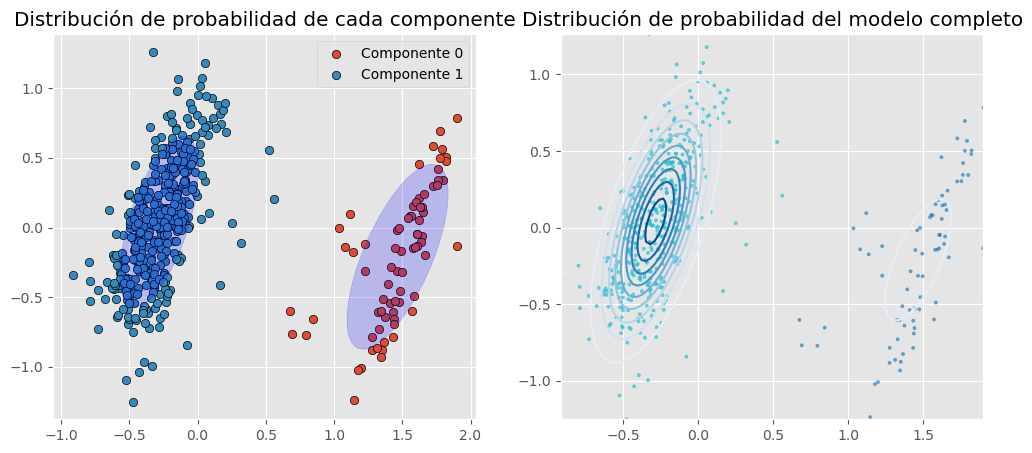

In [124]:
# Aplicar PCA para reducir dimensionalidad a 2D (si es necesario)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Aplicar el modelo GMM en la representación reducida
modelo_gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=123)
modelo_gmm.fit(X_pca)
clasificacion = modelo_gmm.predict(X_pca)

# Función para dibujar las elipses de covarianza
def make_ellipses(gmm, ax):
    for n in range(gmm.n_components):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # Convertir a grados
        v = 2. * np.sqrt(2.) * np.sqrt(v)

        ell = mpl.patches.Ellipse(xy=gmm.means_[n], width=v[0], height=v[1],
                                  angle=angle, color="blue", alpha=0.2)
        ax.add_patch(ell)

# Crear las figuras
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Primer gráfico: distribución de cada componente
for i in np.unique(clasificacion):
    axs[0].scatter(
        X_pca[clasificacion == i, 0], X_pca[clasificacion == i, 1], 
        label=f"Componente {i}", edgecolor='black'
    )

make_ellipses(modelo_gmm, ax=axs[0])
axs[0].set_title('Distribución de probabilidad de cada componente')
axs[0].legend()

# Segundo gráfico: distribución de probabilidad del modelo completo
xs = np.linspace(X_pca[:, 0].min(), X_pca[:, 0].max(), 100)
ys = np.linspace(X_pca[:, 1].min(), X_pca[:, 1].max(), 100)
xx, yy = np.meshgrid(xs, ys)
grid = np.c_[xx.ravel(), yy.ravel()]

scores = modelo_gmm.score_samples(grid)
scores = np.exp(scores)  # Convertir de log a probabilidades

axs[1].scatter(X_pca[:, 0], X_pca[:, 1], s=5, alpha=0.6, c=clasificacion, cmap="tab10")
contour = axs[1].contour(xx, yy, scores.reshape(xx.shape), levels=10, cmap="Blues")
axs[1].set_title('Distribución de probabilidad del modelo completo')

plt.show()


Probando

In [75]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from datetime import datetime, timedelta

# 1️⃣ Lista de acciones a analizar (puedes modificarla)
tickers = ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'APO', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BAX', 'BDX', 'BRK.B', 'BBY', 'TECH', 'BIIB', 'BLK', 'BX', 'BK', 'BA', 'BKNG', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BLDR', 'BG', 'BXP', 'CHRW', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CAT', 'CBOE', 'CBRE', 'CDW', 'COR', 'CNC', 'CNP', 'CF', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CPAY', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CRWD', 'CCI', 'CSX', 'CMI', 'CVS', 'DHR', 'DRI', 'DVA', 'DAY', 'DECK', 'DE', 'DELL', 'DAL', 'DVN', 'DXCM', 'FANG', 'DLR', 'DFS', 'DG', 'DLTR', 'D', 'DPZ', 'DASH', 'DOV', 'DOW', 'DHI', 'DTE', 'DUK', 'DD', 'EMN', 'ETN', 'EBAY', 'ECL', 'EIX', 'EW', 'EA', 'ELV', 'EMR', 'ENPH', 'ETR', 'EOG', 'EPAM', 'EQT', 'EFX', 'EQIX', 'EQR', 'ERIE', 'ESS', 'EL', 'EG', 'EVRG', 'ES', 'EXC', 'EXE', 'EXPE', 'EXPD', 'EXR', 'XOM', 'FFIV', 'FDS', 'FICO', 'FAST', 'FRT', 'FDX', 'FIS', 'FITB', 'FSLR', 'FE', 'FI', 'F', 'FTNT', 'FTV', 'FOXA', 'FOX', 'BEN', 'FCX', 'GRMN', 'IT', 'GE', 'GEHC', 'GEV', 'GEN', 'GNRC', 'GD', 'GIS', 'GM', 'GPC', 'GILD', 'GPN', 'GL', 'GDDY', 'GS', 'HAL', 'HIG', 'HAS', 'HCA', 'DOC', 'HSIC', 'HSY', 'HES', 'HPE', 'HLT', 'HOLX', 'HD', 'HON', 'HRL', 'HST', 'HWM', 'HPQ', 'HUBB', 'HUM', 'HBAN', 'HII', 'IBM', 'IEX', 'IDXX', 'ITW', 'INCY', 'IR', 'PODD', 'INTC', 'ICE', 'IFF', 'IP', 'IPG', 'INTU', 'ISRG', 'IVZ', 'INVH', 'IQV', 'IRM', 'JBHT', 'JBL', 'JKHY', 'J', 'JNJ', 'JCI', 'JPM', 'JNPR', 'K', 'KVUE', 'KDP', 'KEY', 'KEYS', 'KMB', 'KIM', 'KMI', 'KKR', 'KLAC', 'KHC', 'KR', 'LHX', 'LH', 'LRCX', 'LW', 'LVS', 'LDOS', 'LEN', 'LII', 'LLY', 'LIN', 'LYV', 'LKQ', 'LMT', 'L', 'LOW', 'LULU', 'LYB', 'MTB', 'MPC', 'MKTX', 'MAR', 'MMC', 'MLM', 'MAS', 'MA', 'MTCH', 'MKC', 'MCD', 'MCK', 'MDT', 'MRK', 'META', 'MET', 'MTD', 'MGM', 'MCHP', 'MU', 'MSFT', 'MAA', 'MRNA', 'MHK', 'MOH', 'TAP', 'MDLZ', 'MPWR', 'MNST', 'MCO', 'MS', 'MOS', 'MSI', 'MSCI', 'NDAQ', 'NTAP', 'NFLX', 'NEM', 'NWSA', 'NWS', 'NEE', 'NKE', 'NI', 'NDSN', 'NSC', 'NTRS', 'NOC', 'NCLH', 'NRG', 'NUE', 'NVDA', 'NVR', 'NXPI', 'ORLY', 'OXY', 'ODFL', 'OMC', 'ON', 'OKE', 'ORCL', 'OTIS', 'PCAR', 'PKG', 'PLTR', 'PANW', 'PARA', 'PH', 'PAYX', 'PAYC', 'PYPL', 'PNR', 'PEP', 'PFE', 'PCG', 'PM', 'PSX', 'PNW', 'PNC', 'POOL', 'PPG', 'PPL', 'PFG', 'PG', 'PGR', 'PLD', 'PRU', 'PEG', 'PTC', 'PSA', 'PHM', 'PWR', 'QCOM', 'DGX', 'RL', 'RJF', 'RTX', 'O', 'REG', 'REGN', 'RF', 'RSG', 'RMD', 'RVTY', 'ROK', 'ROL', 'ROP', 'ROST', 'RCL', 'SPGI', 'CRM', 'SBAC', 'SLB', 'STX', 'SRE', 'NOW', 'SHW', 'SPG', 'SWKS', 'SJM', 'SW', 'SNA', 'SOLV', 'SO', 'LUV', 'SWK', 'SBUX', 'STT', 'STLD', 'STE', 'SYK', 'SMCI', 'SYF', 'SNPS', 'SYY', 'TMUS', 'TROW', 'TTWO', 'TPR', 'TRGP', 'TGT', 'TEL', 'TDY', 'TER', 'TSLA', 'TXN', 'TPL', 'TXT', 'TMO', 'TJX', 'TKO', 'TSCO', 'TT', 'TDG', 'TRV', 'TRMB', 'TFC', 'TYL', 'TSN', 'USB', 'UBER', 'UDR', 'ULTA', 'UNP', 'UAL', 'UPS', 'URI', 'UNH', 'UHS', 'VLO', 'VTR', 'VLTO', 'VRSN', 'VRSK', 'VZ', 'VRTX', 'VTRS', 'VICI', 'V', 'VST', 'VMC', 'WRB', 'GWW', 'WAB', 'WBA', 'WMT', 'DIS', 'WBD', 'WM', 'WAT', 'WEC', 'WFC', 'WELL', 'WST', 'WDC', 'WY', 'WSM', 'WMB', 'WTW', 'WDAY', 'WYNN', 'XEL', 'XYL', 'YUM', 'ZBRA', 'ZBH', 'ZTS']

# 2️⃣ Descargar datos históricos (últimos 2 años)
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - timedelta(days=2*365)).strftime('%Y-%m-%d')

data = {}
for ticker in tickers:
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    data[ticker] = stock_data["Close"]  # Usamos el precio ajustado de cierre

# Convertir a DataFrame
df_prices = pd.DataFrame(data, index=stock_data.index)

# 3️⃣ Calcular Retornos Diarios y Volatilidad
returns = df_prices.pct_change().dropna()  # Retornos diarios
volatility = returns.std()  # Volatilidad de cada acción

# 4️⃣ Crear el DataFrame con las métricas
features = pd.DataFrame({
    "Mean Return": returns.mean().values,
    "Volatility": volatility.values
}, index=returns.columns)

# 5️⃣ Normalizar datos para el clustering
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# 6️⃣ Aplicar K-Means con 3 Clusters (puedes ajustar el número)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
features["Cluster"] = kmeans.fit_predict(features_scaled)

# 7️⃣ Visualización de Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=features["Volatility"], y=features["Mean Return"], hue=features["Cluster"], palette="viridis", s=100)
for i, txt in enumerate(features.index):
    plt.annotate(txt, (features["Volatility"][i], features["Mean Return"][i]), fontsize=12, alpha=0.7)
plt.xlabel("Volatilidad")
plt.ylabel("Retorno Promedio")
plt.title("Clustering de Acciones según Volatilidad y Retorno Promedio")
plt.show()

# Mostrar los resultados
print(features)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

ValueError: Data must be 1-dimensional, got ndarray of shape (500, 1) instead

# Agregando el cierre de cada empresa desde 2019 al 2024

In [128]:
df = pd.read_csv("acciones_preprocesadas.csv", index_col=0, parse_dates=True)
df = df.drop(df[df["beta"].isna()].index)  # Eliminar filas con valores nulos en shortName
df.isna().sum()  # Verificar si hay valores nulos
df = df.fillna(0)  # Reemplazar valores nulos por 0
# Seleccionar columnas numéricas relevantes para el clustering
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
data = df[numerical_columns]
data.head(3)

,id,prevName,fullTimeEmployees,auditRisk,boardRisk,compensationRisk,shareHolderRightsRisk,overallRisk,governanceEpochDate,compensationAsOfEpochDate,...,2023-12-15 00:00:00,2023-12-18 00:00:00,2023-12-19 00:00:00,2023-12-20 00:00:00,2023-12-21 00:00:00,2023-12-22 00:00:00,2023-12-26 00:00:00,2023-12-27 00:00:00,2023-12-28 00:00:00,2023-12-29 00:00:00
0,1,0,61500.0,1.0,8.0,10.0,4.0,9.0,1.740787e+09,1.735603e+09,...,86.027199,85.134598,85.440170,83.365486,84.885315,85.504501,86.935867,87.442497,88.206421,87.908890
1,2,0,12700.0,5.0,10.0,7.0,10.0,10.0,1.740787e+09,1.735603e+09,...,77.547554,77.733582,79.212082,78.556068,79.858307,80.024765,80.142250,80.445801,80.524117,80.719955
2,3,0,114000.0,7.0,7.0,9.0,2.0,6.0,1.740787e+09,1.672445e+09,...,104.641670,105.392670,105.743790,104.748955,105.802299,106.338730,106.533783,107.079964,107.674911,107.353050


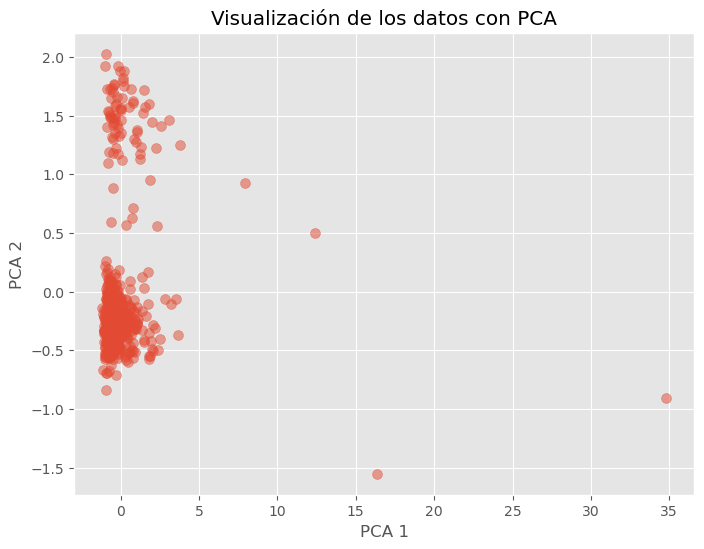

In [129]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(data)  # Reemplazar StandardScaler


# Reducir a 2D con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Graficar los datos en el espacio reducido
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, s=50)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Visualización de los datos con PCA")
plt.show()


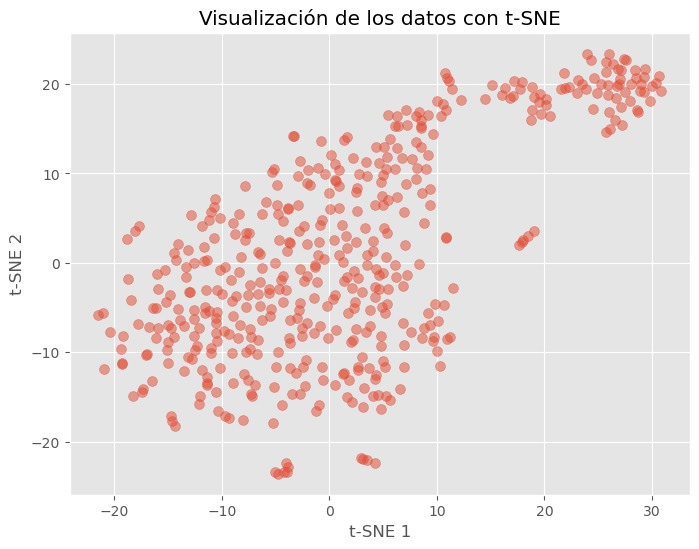

In [130]:
from sklearn.manifold import TSNE

# Reducir dimensiones con t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Graficar los datos en el espacio t-SNE
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.5, s=50)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("Visualización de los datos con t-SNE")
plt.show()

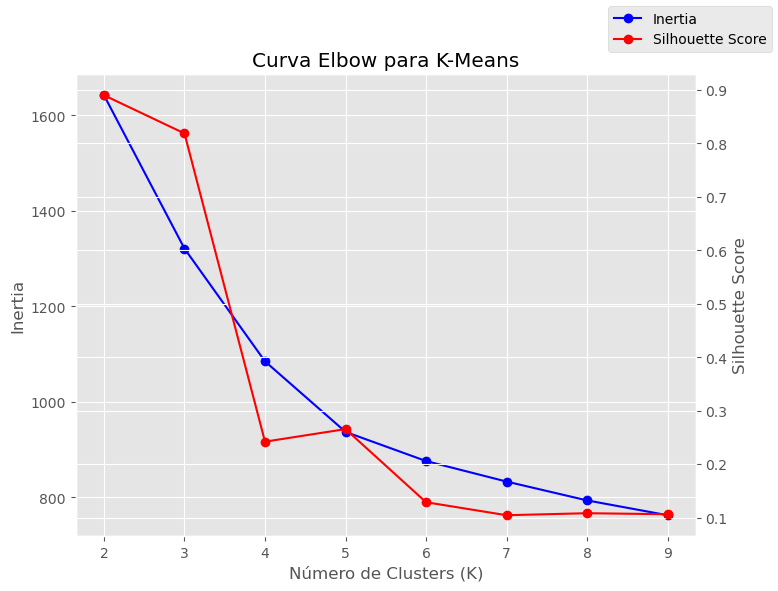

In [131]:
inertia = []
silhouette = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled, labels))

# Graficar Elbow y Silhouette Score
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.plot(K_range, inertia, 'bo-', label="Inertia")
ax1.set_xlabel("Número de Clusters (K)")
ax1.set_ylabel("Inertia")
ax1.set_title("Curva Elbow para K-Means")

ax2 = ax1.twinx()
ax2.plot(K_range, silhouette, 'ro-', label="Silhouette Score")
ax2.set_ylabel("Silhouette Score")

fig.legend()
plt.show()


Mejor algoritmo según la métrica de silueta: K-Means


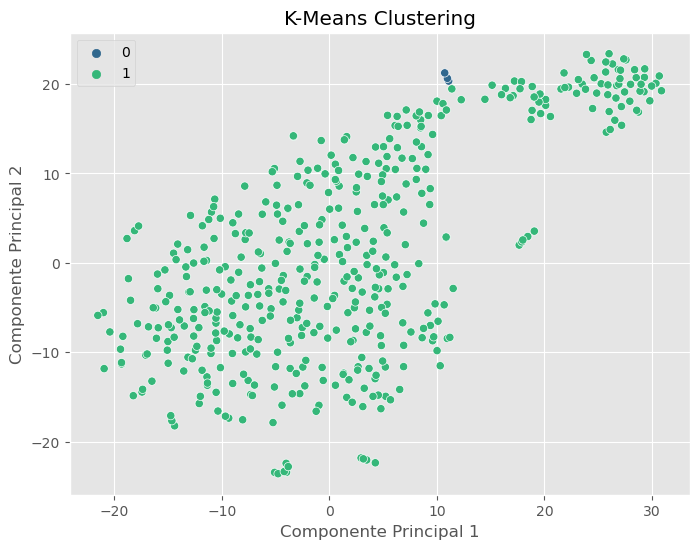

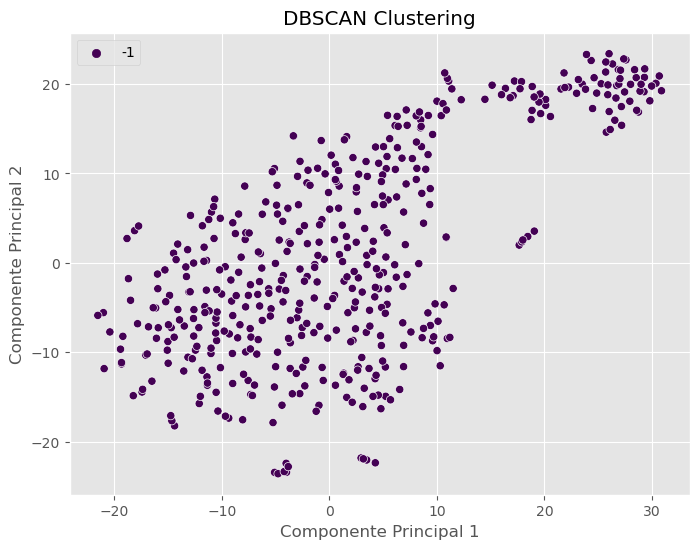

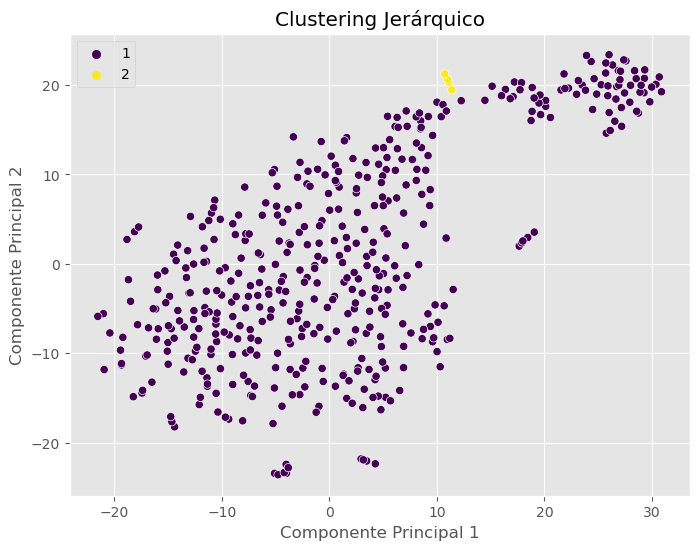

In [ ]:
# # Escalar los datos
# scaler = StandardScaler()
# data_scaled = scaler.fit_transform(data)

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)  # Reemplazar StandardScaler

# Aplicar K-Means
kmeans = KMeans(n_clusters=2, random_state=42, n_init=25)
kmeans_labels = kmeans.fit_predict(data_scaled)
kmeans_silhouette = silhouette_score(data_scaled, kmeans_labels)

# Aplicar DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(data_scaled)
dbscan_silhouette = silhouette_score(data_scaled, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1

# Aplicar Clustering Jerárquico
linkage_matrix = linkage(data_scaled, method='ward')
hierarchical_labels = fcluster(linkage_matrix, t=2, criterion='maxclust')
hierarchical_silhouette = silhouette_score(data_scaled, hierarchical_labels)

# Elegir el mejor algoritmo
scores = {
    'K-Means': kmeans_silhouette,
    'DBSCAN': dbscan_silhouette,
    'Jerárquico': hierarchical_silhouette
}
best_algorithm = max(scores, key=scores.get)
print(f"Mejor algoritmo según la métrica de silueta: {best_algorithm}")

# Reducir dimensionalidad con PCA para graficar
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)
# Reducir dimensiones con t-SNE
# tsne = TSNE(n_components=2, perplexity=30, random_state=42)
# data_pca = tsne.fit_transform(data_scaled)

# Función para graficar resultados
def plot_clusters(labels, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=labels, palette='viridis', legend='full')
    plt.title(title)
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.show()

# Graficar cada resultado
plot_clusters(kmeans_labels, "K-Means Clustering")
plot_clusters(dbscan_labels, "DBSCAN Clustering")
plot_clusters(hierarchical_labels, "Clustering Jerárquico")